## Visualization of supervised and supervised model side by side

In [1]:
# imports
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tf_dataset.tf_dataset import get_tf_dataset
from model.models import get_model


2024-03-03 17:23:18.827543: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-03 17:23:18.854071: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 17:23:18.854092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 17:23:18.854745: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-03 17:23:18.858982: I tensorflow/core/platform/cpu_feature_guar

In [13]:
# test dataset
test_ds_path = '/home/ji/Dropbox/Robotics/CMSC733/Project1/Phase2/Data/Test'
ds = get_tf_dataset(path=test_ds_path,
                    batch_size=8,
                    mode="unsupervised")


In [20]:

# retrieve a sample batch
sample_input, sample_output = next(iter(ds))
im_crop1, im_crop2, im_ori, upper_left_coord = sample_input
im_warp, h4pt = sample_output

# convert to numpy arrays
im_crop1 = im_crop1.numpy()
im_crop2 = im_crop2.numpy()
im_ori = im_ori.numpy()
upper_left_coord = upper_left_coord.numpy().astype(int)
im_warp = im_warp.numpy()
h4pt = h4pt.numpy().astype(int)

print(im_ori.shape, im_warp.shape, upper_left_coord.shape, h4pt.shape)

(8, 240, 320, 3) (8, 240, 320, 3) (8, 2) (8, 8)


In [3]:
# load models
model_s = get_model(mode="supervised")
model_s.load_weights("./chkpt/mdl_supervised_rho32")

model_us = get_model(mode="unsupervised")
model_us.load_weights("./chkpt/mdl_unsupervised_rho32")

new init
new init


2024-03-03 17:23:27.320526: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-03 17:23:27.671525: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x94af5c0


checking nan


In [21]:
# call model
h4pt_s = model_s([im_crop1,im_crop2])
h4pt_s = np.round(h4pt_s.numpy())

model_out_us = model_us(sample_input)
im_warp_pred_us, h4pt_us = model_out_us
im_warp_pred_us = np.round(im_warp_pred_us.numpy()*255)
h4pt_us = np.round(h4pt_us.numpy())

In [5]:
def plot_box(im, pts, color=1):
    if color == 1:
        c = (0,0,255)
    elif color == 2:
        c = (255,0,0)
    elif color == 3:
        c = (255,166,0)
    for i in range(4):
        cv2.line(im,
                 (np.flip(pts[i,:].astype(int))),
                 (np.flip(pts[int((i+1)%4)].astype(int))),
                 color=c, thickness=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


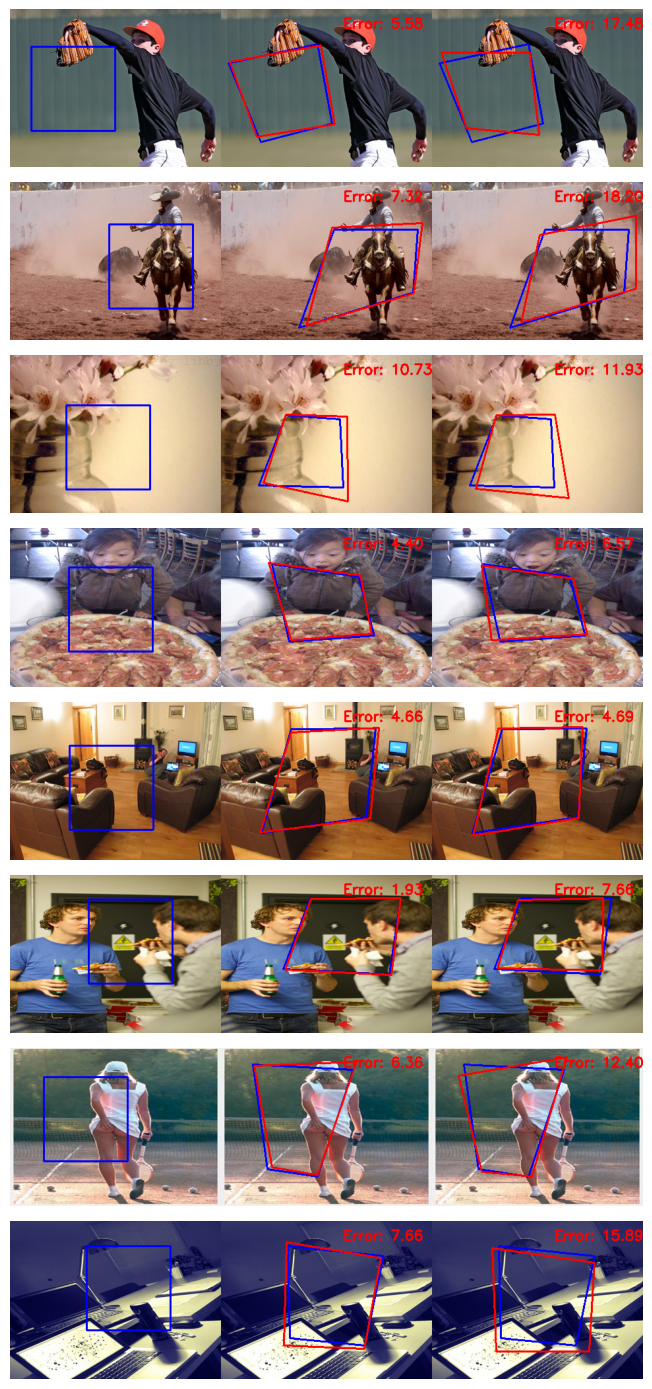

In [22]:
def Mean_Corner_error(corners1, corners2):
    assert corners1.shape == corners2.shape
    distances = np.sqrt(np.sum(np.square(corners1 - corners2), axis=1))
    mean_error = np.mean(distances)
    return mean_error

def plot_box(im, pts, color=1):
    if color == 1:
        c = (0,0,255)
    elif color == 2:
        c = (255,0,0)
    elif color == 3:
        c = (255,166,0)
    for i in range(4):
        cv2.line(im,
                 (np.flip(pts[i,:].astype(int))),
                 (np.flip(pts[int((i+1)%4)].astype(int))),
                 color=c, thickness=2)

def plot_result(h4pt_us,
                h4pt_s,
                im_ori,
                h4pt,
                upper_left,
                crop_sz=128,):
    ch = crop_sz
    cw = crop_sz
    h,w = im_ori.shape[1:3]
    B = im_ori.shape[0]

    plt.figure(figsize=(8,14))
    for b in range(B):
        upper_left_coord = upper_left[[b],:]
        corners = upper_left_coord + np.array([[0,0],
                                              [ch-1,0],
                                              [ch-1,cw-1],
                                              [0,cw-1]])
        
        corners_shift = corners - np.reshape(h4pt[[b],:],(4,2))
        corners_shift_pred_s = corners - np.reshape(h4pt_s[[b]],(4,2))
        corners_shift_pred_us = corners - np.reshape(h4pt_us[[b]],(4,2))

        error_s = Mean_Corner_error(corners_shift, corners_shift_pred_s)
        error_us = Mean_Corner_error(corners_shift, corners_shift_pred_us)

        im_ori_this = np.squeeze(im_ori[b,:,:,:])

        # plot the corners on the original image
        im_ori0 = im_ori_this.copy()
        plot_box(im_ori0, corners, color=1)

        # supervised performance
        im_ori1 = im_ori_this.copy()
        fs = 0.7
        c = (255,0,0)
        org = (185,30)
        cv2.putText(im_ori1, text=f"Error: {error_s:.2f}", org=org,
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=fs,
                    color=c,
                    thickness=2)
        plot_box(im_ori1, corners_shift, color=1)
        plot_box(im_ori1, corners_shift_pred_s, color=2)

        # unsupervised performance
        im_ori2 = im_ori_this.copy()
        cv2.putText(im_ori2, text=f"Error: {error_us:.2f}", org=org,
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=fs,
                    color=c,
                    thickness=2)
        plot_box(im_ori2, corners_shift, color=1)
        plot_box(im_ori2, corners_shift_pred_us, color=2)

        plt.subplot(B,1,b+1)
        plt.imshow(np.hstack((im_ori0, im_ori1, im_ori2)))
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig("./results/"+f"visualization.",dpi=300) 
    plt.show()

plot_result(h4pt_s=h4pt_s,
            h4pt_us=h4pt_us,
            im_ori=im_ori,
            h4pt=h4pt,
            upper_left=upper_left_coord)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


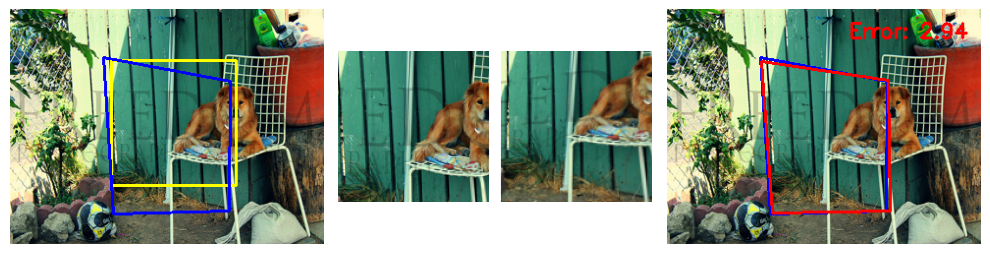

In [32]:
# plot the idea of the transform

def plot_transform(h4pt_s,
                im_crop1,
                im_crop2,
                im_ori,
                h4pt,
                upper_left,
                crop_sz=128,):
    ch = crop_sz
    cw = crop_sz
    h,w = im_ori.shape[1:3]
    B = im_ori.shape[0]

    plt.figure(figsize=(10,6))
    b = 0
    upper_left_coord = upper_left[[b],:]
    corners = upper_left_coord + np.array([[0,0],
                                            [ch-1,0],
                                            [ch-1,cw-1],
                                            [0,cw-1]])
    
    corners_shift = corners - np.reshape(h4pt[[b],:],(4,2))
    corners_shift_pred_s = corners - np.reshape(h4pt_s[[b]],(4,2))
    corners_shift_pred_us = corners - np.reshape(h4pt_us[[b]],(4,2))

    error_s = Mean_Corner_error(corners_shift, corners_shift_pred_s)
    error_us = Mean_Corner_error(corners_shift, corners_shift_pred_us)

    im_ori_this = np.squeeze(im_ori[b,:,:,:])

    # plot the corners on the original image
    im_ori0 = im_ori_this.copy()
    plot_box(im_ori0, corners, color=3) # plot in orange
    plot_box(im_ori0, corners_shift, color=1)

    plt.subplot(1,3,1)
    plt.imshow(im_ori0)
    plt.axis("off")

    plt.subplot(1,3,2)
    imc1,imc2 = np.squeeze(im_crop1[b,:,:,:]/255),\
                np.squeeze(im_crop2[b,:,:,:]/255)
    plt.imshow(np.hstack((imc1,np.ones((128,10,3)),imc2)))
    plt.axis("off")

    # supervised performance
    im_ori1 = im_ori_this.copy()
    fs = 0.7
    c = (255,0,0)
    org = (185,30)
    cv2.putText(im_ori1, text=f"Error: {error_s:.2f}", org=org,
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=fs,
                color=c,
                thickness=2)
    plot_box(im_ori1, corners_shift, color=1)
    plot_box(im_ori1, corners_shift_pred_s, color=2)
    plt.subplot(1,3,3)
    plt.imshow(im_ori1)
    plt.axis("off")

    plt.tight_layout()
    plt.savefig("./results/"+f"transform_illustration.",dpi=300) 
    plt.show()

plot_transform(
            im_crop1=im_crop1,
            im_crop2=im_crop2,
            h4pt_s=h4pt_s,
            im_ori=im_ori,
            h4pt=h4pt,
            upper_left=upper_left_coord)